In [1]:
date()

[1] "Sun Nov 13 20:56:05 2016"

# Chapter 7
## 7.1

In [2]:
sapply(c("pipeR", "dplyr", "tidyr", "ggplot2", "readr"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE

In [3]:
d <- readr::read_csv("data/chap07/data.csv")
str(d)

Parsed with column specification:
cols(
  N = col_integer(),
  y = col_integer(),
  x = col_integer(),
  id = col_integer()
)


Classes 'tbl_df', 'tbl' and 'data.frame':	100 obs. of  4 variables:
 $ N : int  8 8 8 8 8 8 8 8 8 8 ...
 $ y : int  0 1 2 4 1 0 0 7 1 6 ...
 $ x : int  2 2 2 2 2 2 2 2 2 2 ...
 $ id: int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 4
  .. ..$ N : list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ y : list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ x : list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ id: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


In [4]:
options(repr.plot.width = 4, repr.plot.height = 4)

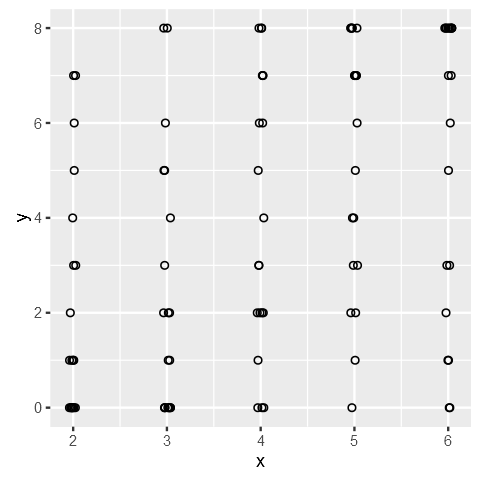

In [5]:
d %>>% ggplot(aes(x = x, y = y)) + 
    geom_point(shape = 21, position = position_jitter(w = 0.1, h = 0))

In [6]:
fit.glm <- glm(cbind(y, N - y) ~ x, data = d, family = binomial)
summary(fit.glm)


Call:
glm(formula = cbind(y, N - y) ~ x, family = binomial, data = d)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4736  -2.1182  -0.5505   2.3097   4.0966  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.1487     0.2372  -9.057   <2e-16 ***
x             0.5104     0.0556   9.179   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 607.42  on 99  degrees of freedom
Residual deviance: 513.84  on 98  degrees of freedom
AIC: 649.61

Number of Fisher Scoring iterations: 4


In [7]:
logistic <- function(x, beta1, beta2){
    1 / (1 + exp(-(beta1 + beta2 * x)))
}

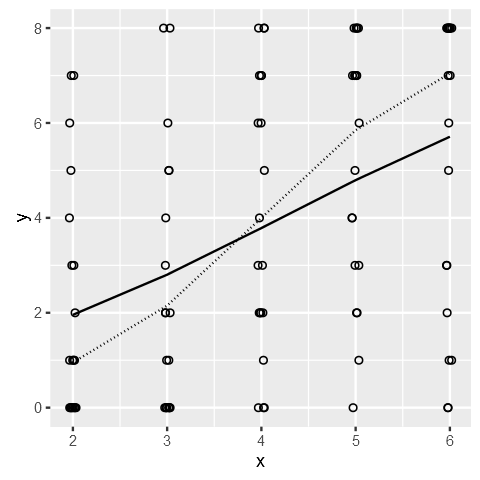

In [8]:
d %>>% 
    mutate(pred.true = logistic(d$x, -4, 1), 
           pred = predict(fit.glm, newdata = data.frame(x = d$x), type = "response")) %>>% 
    ggplot() + 
    geom_point(aes(x = x, y = y), shape = 21, position = position_jitter(w = 0.1, h = 0)) + 
    geom_line(aes(x = x, y = 8 * pred)) + 
    geom_line(aes(x = x, y = 8 * pred.true), linetype = "dotted")

## 7.2 過分散と個体差
### 7.2.1

In [9]:
d %>>% filter(x == 4) %>>% (y) %>>% table()

.
0 1 2 3 4 5 6 7 8 
3 1 4 2 1 1 2 3 3 

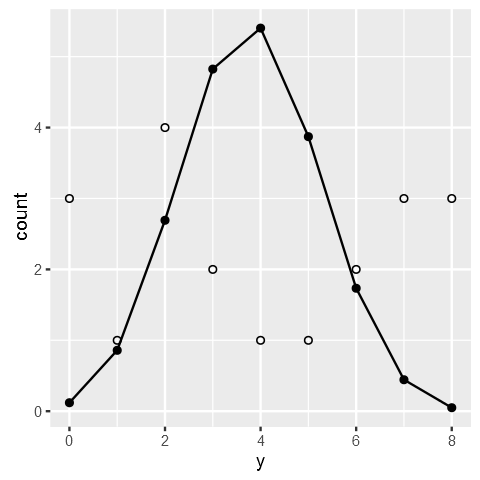

In [10]:
d %>>% filter(x == 4) %>>% 
    {ggplot(data = (.), aes(x = y)) + 
    stat_count(geom = "point", shape = 21) + 
    stat_function(geom="point", n=9, fun = function(x, size, prob){dbinom(x, size = size, prob = prob) * nrow(.)}, 
                  args = list(size = 8, prob = logistic(4, -2.15, 0.51))) + 
    stat_function(geom="line", n=9, fun = function(x, size, prob){dbinom(x, size = size, prob = prob) * nrow(.)}, 
                  args = list(size = 8, prob = logistic(4, -2.15, 0.51)))}

In [11]:
d %>>% filter(x == 4) %>>% summarize_each(funs(mean, var), y)

mean,var
4.05,8.365789


生存確率の平均は

In [12]:
4.05 / 8

[1] 0.50625

二項分布の分散: `np(1 - p)`

In [13]:
logistic(4, -2.15, 0.51) %>>% {8 * (.) * (1 - (.))}

[1] 1.993962

### 7.2.2

### 7.2.3


## 7.3 一般化線形混合モデル
### 7.3.1

* 生存確率 $q_i$ に 個体差 $r_i$ を加える

$$\text{logit}(q_i) = \beta_1 + \beta_2 x_i + r_i$$

### 7.3.2
* $r_i$ は平均 0，標準偏差 $s$ の正規分布に従うとする
* $r_i$ は独立

$$ p(r_i | s) = \frac{1}{\sqrt{2 \pi s^2}} \exp \left( -\frac{r_i^2}{2 s^2} \right) $$

### 7.3.3

## 7.4 一般化線形混合モデルの最尤推定

$L(\beta_1, \beta_2, s) = \prod\limits_i L_i $ より，対数尤度 $log L(\beta_1, \beta_2, s)$ を最大にする

ランダム効果なし（6章）

$$ p(y | N, q) = \binom{N}{y} q^y(1 - q)^{N - y} $$

$$ L(\{ \beta_j \}) = \prod\limits_i p(y_i | N_i, q_i)$$

今回

$$ L_i = \int^\infty_{-\infty} p(y_i | \beta_1, \beta_2, r_i) p(r_i | s )dr_i $$

個体ごとの尤度?

$$ q_i \sim \int^\infty_{-\infty} (\beta_1 + \beta_2 x_i + r_i) dr_i$$

### 7.4.1

In [15]:
library(glmmML)

* Gauss-Hermite求積法

In [18]:
fit.glmm <- glmmML(cbind(y, N - y) ~ x, data = d, family = binomial, cluster = id, method = "ghq")
fit.glmm


Call:  glmmML(formula = cbind(y, N - y) ~ x, family = binomial, data = d,      cluster = id, method = "ghq") 


               coef se(coef)      z Pr(>|z|)
(Intercept) -4.1296   0.9055 -4.561 5.10e-06
x            0.9903   0.2141  4.625 3.75e-06

Scale parameter in mixing distribution:  2.494 gaussian 
Std. Error:                              0.3093 

        LR p-value for H_0: sigma = 0:  1.792e-56 

Residual deviance: 264.5 on 97 degrees of freedom 	AIC: 270.5 

* Laplace 近似

In [19]:
fit.glmm2 <- glmmML(cbind(y, N - y) ~ x, data = d, family = binomial, cluster = id)
fit.glmm2


Call:  glmmML(formula = cbind(y, N - y) ~ x, family = binomial, data = d,      cluster = id) 


              coef se(coef)      z Pr(>|z|)
(Intercept) -4.190   0.8777 -4.774 1.81e-06
x            1.005   0.2075  4.843 1.28e-06

Scale parameter in mixing distribution:  2.408 gaussian 
Std. Error:                              0.2202 

        LR p-value for H_0: sigma = 0:  2.136e-55 

Residual deviance: 269.4 on 97 degrees of freedom 	AIC: 275.4 

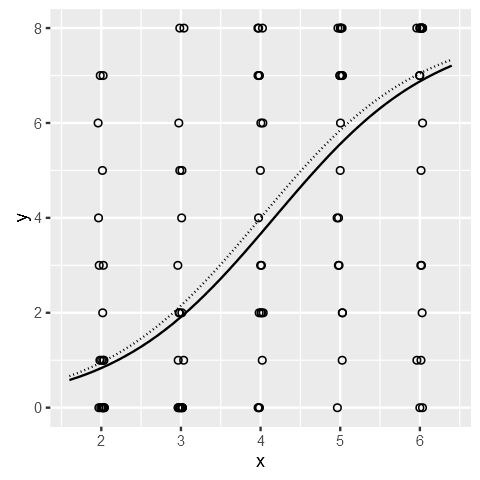

In [30]:
data_frame(xx = seq(1.6, 6.4, 0.1)) %>>% 
    mutate(pred.true = logistic(xx, -4, 1), 
           pred = logistic(xx, fit.glmm$coefficients[1], fit.glmm$coefficients[2])) %>>% 
    ggplot() + 
    geom_point(mapping = aes(x = x, y = y), data = d, shape = 21, position = position_jitter(w = 0.1, h = 0)) + 
    geom_line(aes(x = xx, y = 8 * pred)) + 
    geom_line(aes(x = xx, y = 8 * pred.true), linetype = "dotted")

## 7.5 現実のデータ解析にはGLMMが必要
* 反復
* 疑似反復
### 7.5.1

## 7.6 いろいろな分布のGLMM

## 7.7 まとめと参考文献